# Session 6

Time Series

## Modelling case

I'm using a dataset downloaded from the National Centers for Environmental Information (NCEI), the data is in the public domain and can be used freely.
In case using the same dataset or generating a new one from NCEI you need to cite the origin.
The Dataset covers each day from 2010 to 2019 and the station used is located at Heathrow Airport in London.

- DATE: is the year of the record (4 digits) followed by month (2 digits) and day (2 digits).
- PRCP: Precipitation (mm)
- TAVG: Average temperature (°C)

## Dataset exploration and cleaning

In [1]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pathlib import Path

# specifying file name
file = Path('data').joinpath('HeathrowMeteo2010-2019.csv')

# setting pandas print options
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

# reading the file into Python
df = pd.read_csv(file,
                       usecols=['DATE', 'PRCP', 'TAVG'],
                       parse_dates=['DATE'])

df.columns = ['date', 'precipitation', 'avg_temp']

df = df.set_index('date')

# outputting the first ten rows of the dataset
df.head(n = 10)

,precipitation,avg_temp
date,,
2010-01-01,0.0,0.8
2010-01-02,0.0,1.8
2010-01-03,0.0,0.4
2010-01-04,0.0,-2.8
2010-01-05,0.3,-1.3
2010-01-06,1.5,-0.1
2010-01-07,3.0,-2.3
2010-01-08,1.0,-1.4
2010-01-09,0.3,-1.2


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3621 entries, 0 to 3620
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           3621 non-null   datetime64[ns]
 1   precipitation  3591 non-null   float64       
 2   avg_temp       3621 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 85.0 KB


In [84]:

df.isnull().sum()

date              0
precipitation    30
avg_temp          0
dtype: int64

Need to fill in the mission values. In this case we fill them with 0 for 'no-rain'.

In [6]:
df['precipitation'].fillna(0, inplace=True)
df.isnull().sum()

precipitation    0
avg_temp         0
dtype: int64

Also need to check fo rmissing days in the range.

In [86]:
print(f"Data Available from {df.date.min()} to {df.date.max()}")

Data Available from 2010-01-01 00:00:00 to 2019-12-31 00:00:00


In [87]:
idx = pd.date_range(df.date.min(), df.date.max())
print(f"Days present {len(df)} out of {len(idx)}")

Days present 3621 out of 3652


In [2]:
# As we are missing days we need to fill the values

# Option 1: forward fill - the values for a missing date are filled with the last observed

df.resample('D').ffill()

,precipitation,avg_temp
date,,
2010-01-01,0.0,0.8
2010-01-02,0.0,1.8
2010-01-03,0.0,0.4
2010-01-04,0.0,-2.8
2010-01-05,0.3,-1.3
...,...,...
2019-12-27,2.5,7.3
2019-12-28,0.0,8.0
2019-12-29,0.0,7.3


In [34]:
# Option 2: backward fill - the values for a missing date are filled with the next observed

df.resample('D').bfill()

In [36]:
# Option 3: interpolation - the values for a missing date are filled with the value that fits best between the last and the next

df.resample('D').interpolate(method='linear')

,precipitation,avg_temp
date,,
2010-01-01,0.0,0.8
2010-01-02,0.0,1.8
2010-01-03,0.0,0.4
2010-01-04,0.0,-2.8
2010-01-05,0.3,-1.3
...,...,...
2019-12-27,2.5,7.3
2019-12-28,0.0,8.0
2019-12-29,0.0,7.3


Let's do forward fill

In [3]:
df = df.resample('D').ffill()

Let's add some features for vizulizations

In [41]:
df = df.reset_index()
df['month'] = df.date.dt.month
df['year'] = df.date.dt.year
df['day'] = df.date.dt.day
df['weekdayName'] = df.date.dt.day_name() # df.date.dt.weekday_name on older Pandas
df['weekday'] = df.date.dt.weekday
df['weekend'] = df.date.dt.weekday // 5 == 1
df['raining'] = df['precipitation'].gt(1.0).astype('int')

In [53]:
import calendar

# Look at the average precipitation per month for all years
all_month_year_df = pd.pivot_table(df,
                                   values="precipitation",
                                   index=["month"],
                                   columns=["year"],
                                   fill_value=0,
                                   margins=True)

# assign monthnames as indices
named_index = [[calendar.month_abbr[i] if isinstance(i, int) else i for i in list(all_month_year_df.index)]]
all_month_year_df = all_month_year_df.set_index(named_index)
all_month_year_df

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,All
Jan,1.687097,2.506452,0.996774,1.309677,4.783871,1.964516,2.383871,1.867742,1.329032,0.929032,1.975806
Feb,3.196429,1.535714,0.579310,1.389286,3.671429,1.457143,1.572414,1.450000,0.989286,1.346429,1.714184
Mar,1.641935,0.464516,0.561290,1.554839,1.041935,0.835484,2.367742,0.887097,2.680645,1.654839,1.369032
Apr,0.726667,0.086667,2.926667,1.130000,1.880000,0.276667,1.593333,0.123333,2.156667,0.426667,1.132667
May,0.764516,0.806452,0.835484,1.332258,2.841935,0.819355,1.567742,2.151613,1.964516,1.164516,1.424839
Jun,0.250000,2.643333,3.390000,0.400000,1.356667,0.423333,3.513333,1.546667,0.016667,2.736667,1.627667
Jul,0.548387,1.561290,1.835484,0.819355,1.622581,2.325806,0.541935,2.932258,0.483871,1.632258,1.430323
Aug,3.019355,2.154839,1.141935,1.067742,3.174194,3.412903,0.700000,1.858065,1.538710,1.100000,1.916774
Sep,1.033333,1.160000,1.230000,1.676667,0.360000,2.056667,1.316667,1.946667,0.563333,1.856667,1.320000
Oct,2.000000,0.409677,2.454839,1.596774,2.480645,1.296774,0.800000,0.448387,1.845161,3.125806,1.645806


In [52]:
# Create a reusable heatmap function

def plot_heatmap(df, title):
    plt.figure(figsize = (14, 10))
    ax = sns.heatmap(df,
                     cmap='RdYlGn_r',
                     robust=True,
                     fmt='.2f',
                     annot=True,
                     linewidths=.5,
                     annot_kws={'size':11},
                     cbar_kws={'shrink':.8, 'label':'Precipitation (mm)'})
    
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
    plt.title(title, fontdict={'fontsize':18}, pad=14)


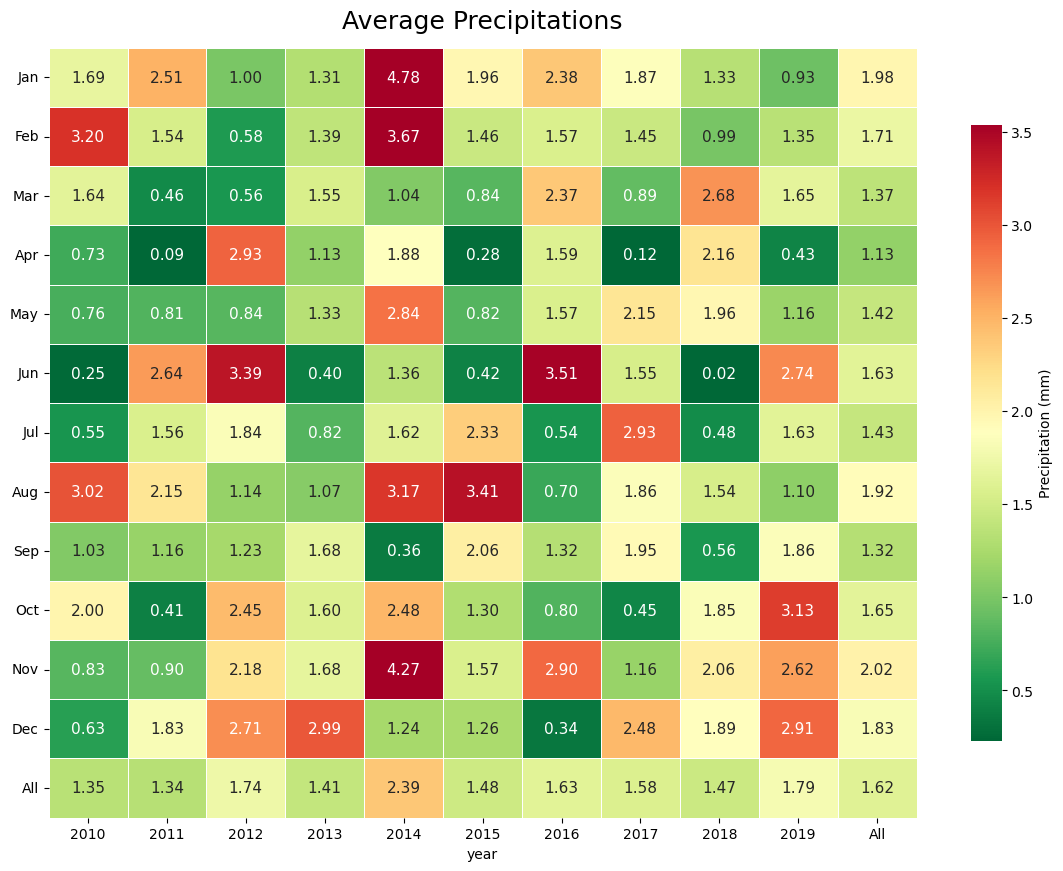

In [51]:
plot_heatmap(all_month_year_df, 'Average Precipitations')

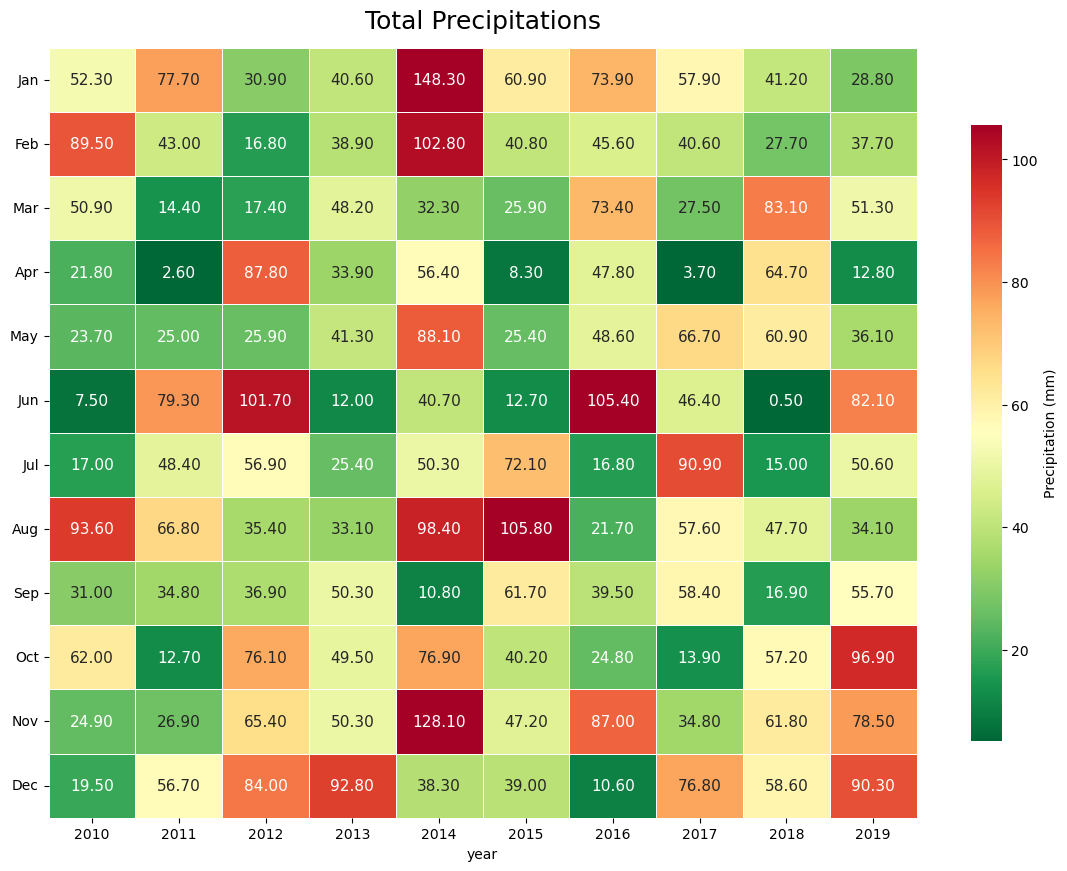

In [54]:
# Look at the total precipitations

all_month_year_sum_df = pd.pivot_table(df,
                                       values="precipitation",
                                       index=["month"],
                                       columns=["year"],
                                       aggfunc=np.sum,
                                       fill_value=0)
all_month_year_sum_df = all_month_year_sum_df.set_index([[calendar.month_abbr[i] if isinstance(i, int) else i for i in list(all_month_year_sum_df.index)]])
plot_heatmap(all_month_year_sum_df, 'Total Precipitations')

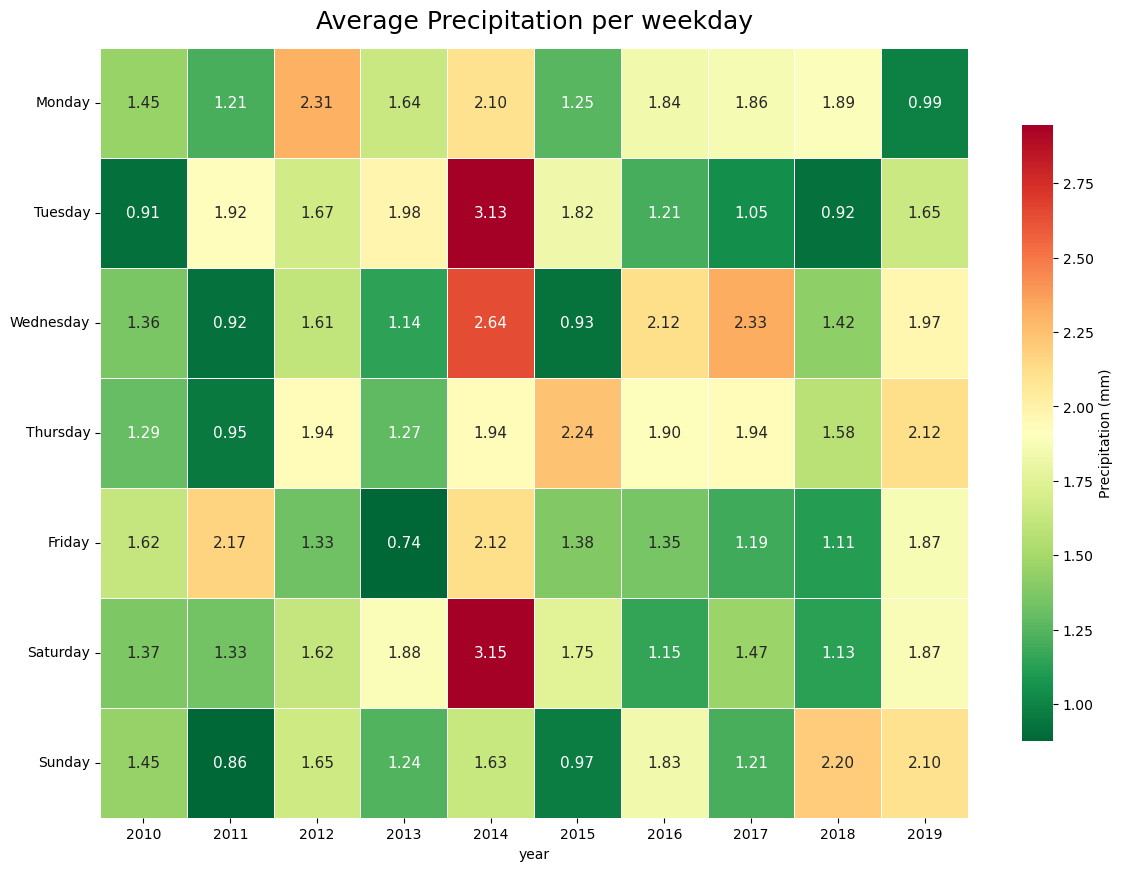

In [55]:
# Look at the average precipitations per weekday

all_weekday_year_df = pd.pivot_table(df,
                                     values="precipitation",
                                     index=["weekday"],
                                     columns=["year"],
                                     fill_value=0.0)
all_weekday_year_df = all_weekday_year_df.set_index([[calendar.day_name[i] for i in list(all_weekday_year_df.index)]])
plot_heatmap(all_weekday_year_df, 'Average Precipitation per weekday')

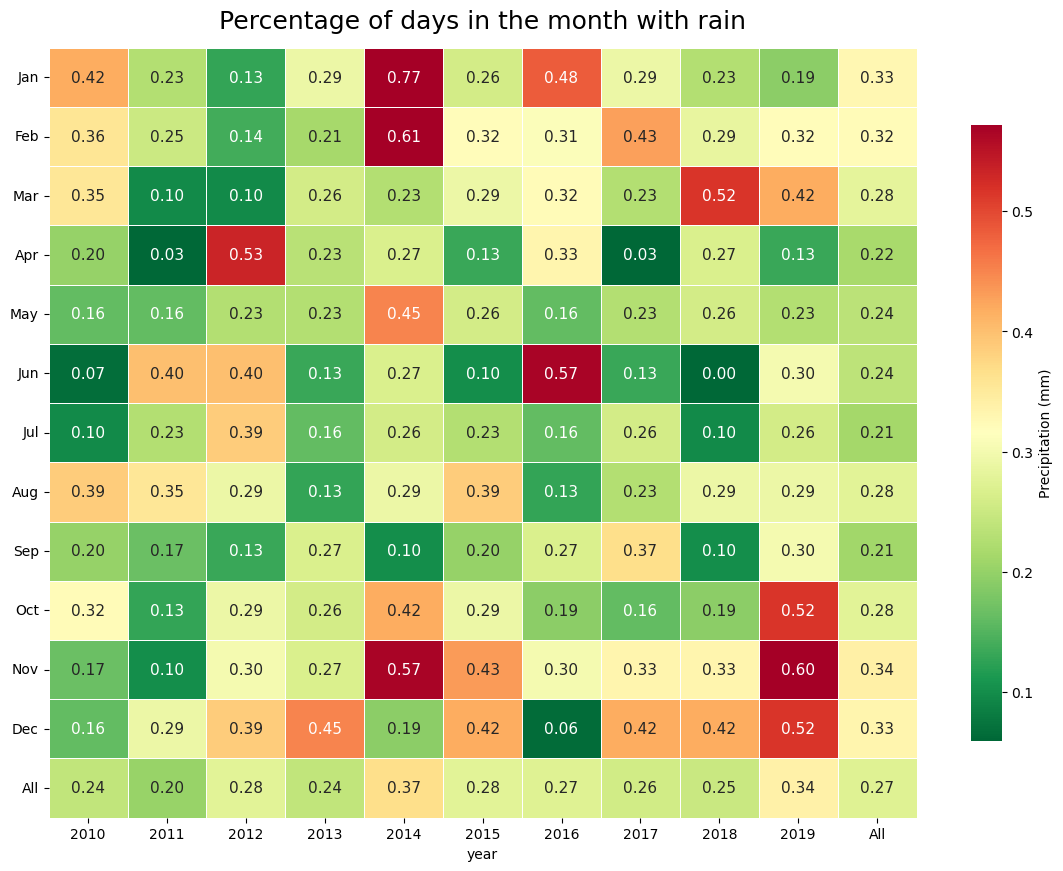

In [56]:
# Percentage of days in the month with rain

all_month_year_percentage_df = pd.pivot_table(df,
                                              values="precipitation",
                                              index=["month"],
                                              columns=["year"],
                                              aggfunc=lambda x: (x>1.0).sum()/len(x),
                                              fill_value=0,
                                              margins=True)
all_month_year_percentage_df = all_month_year_percentage_df.set_index([[calendar.month_abbr[i] if isinstance(i, int)
                                                                        else i for i in list(all_month_year_percentage_df.index)]])
plot_heatmap(all_month_year_percentage_df, 'Percentage of days in the month with rain')



Text(0.5, 1.0, 'Percentage of days in the month with rain')

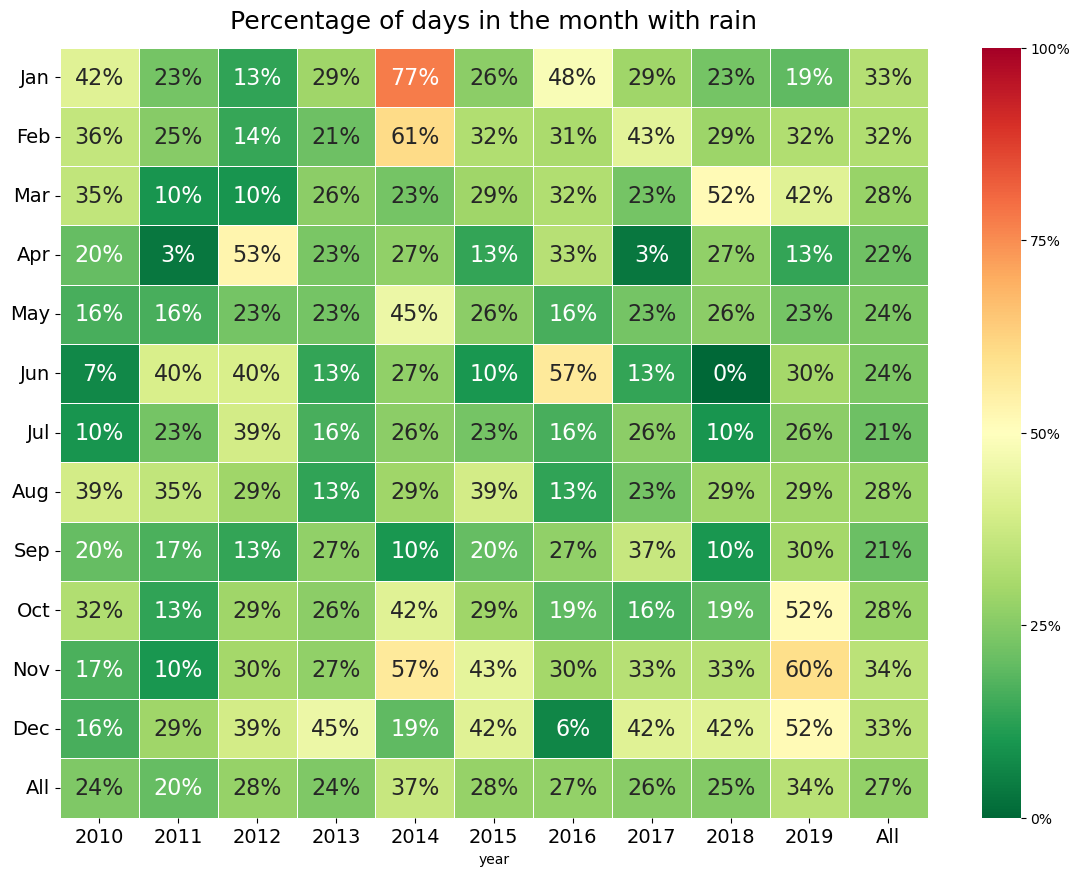

In [57]:
# making this nicer

plt.figure(figsize = (14, 10))
ax = sns.heatmap(all_month_year_percentage_df,
                 cmap = 'RdYlGn_r',
                 annot=True,
                 fmt='.0%',
                 vmin=0,
                 vmax=1,
                 linewidths=.5,
                 annot_kws={"size": 16})
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .50,.75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_yticklabels(ax.get_yticklabels(),
                   rotation = 0,
                   fontsize = 14)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation = 0,
                   fontsize = 14)
ax.tick_params(rotation = 0)
plt.title('Percentage of days in the month with rain', fontdict={'fontsize':18}, pad=14)

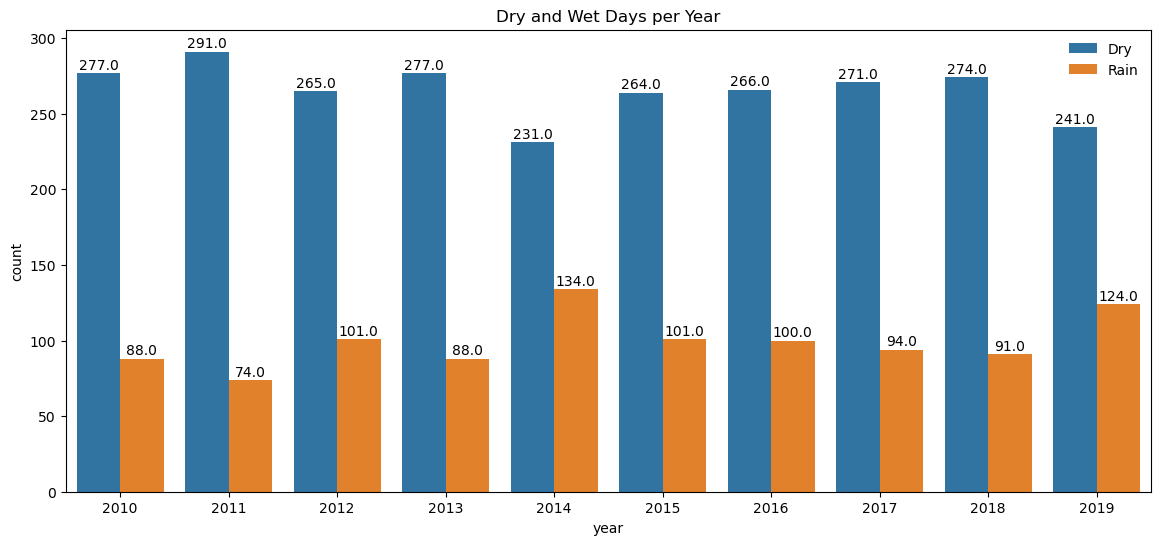

In [58]:
# Dry and wet days per year

plt.figure(figsize = (14, 6))
ax = sns.countplot(x="year",
                   hue="raining",
                   data=df.sort_values(by='year'))
ax.legend(loc='upper right',
          frameon=False,
          labels=['Dry', 'Rain'])

for p in ax.patches:
    ax.annotate(format(p.get_height()),
                (p.get_x()+p.get_width()/2., p.get_height()-4),
                ha = 'center', va = 'center',
                xytext = (0, 10), textcoords = 'offset points')

_ = ax.set_title("Dry and Wet Days per Year")

## Looking at the timeseries

<Axes: xlabel='date', ylabel='avg_temp'>

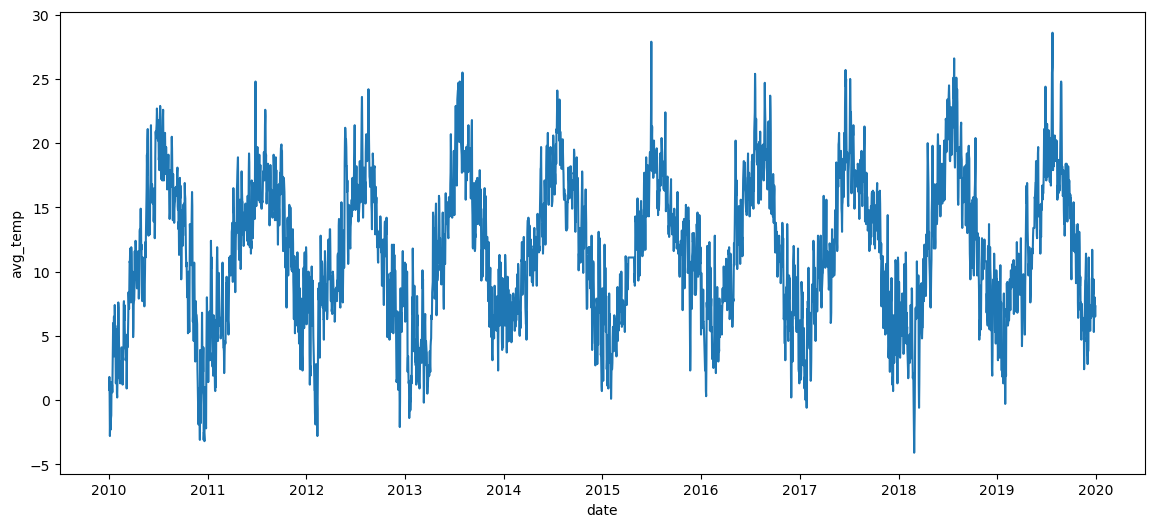

In [107]:
plt.figure(figsize = (14, 6))
sns.lineplot(data = df,
             x='date',
             y='avg_temp')

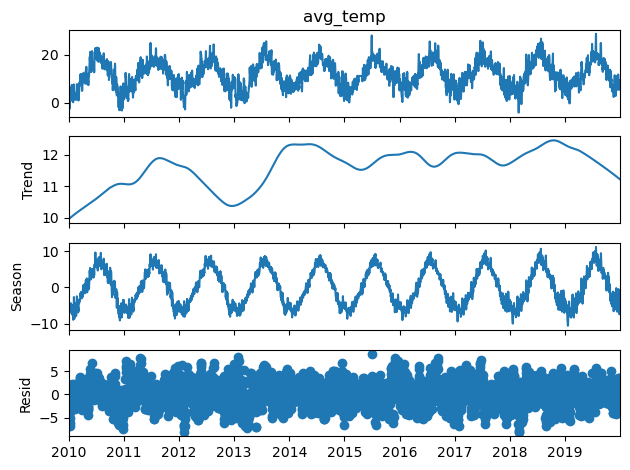

In [118]:
from statsmodels.tsa.seasonal import STL

# period is the periodicy - in this case yearly or 365 days
# seasonal is a smoothener for the seasonality - set to 1 month or 31 days (must be odd)

stl = STL(df['avg_temp'], period=365, seasonal=31)
res_new = stl.fit()
fig = res_new.plot()

## Forecasting climate data

In [19]:
!pip install meteostat

  Obtaining dependency information for meteostat from https://files.pythonhosted.org/packages/23/93/0d277de2b38238072b850e33fbd94e230951f2e5d7ac140ae221a05215b0/meteostat-1.6.7-py3-none-any.whl.metadata


In [20]:
import datetime
from meteostat import Point, Monthly

# Set time period
start = datetime.datetime(1970, 1, 1)
end = datetime.datetime(2023, 12, 31)

# Create Point for Madrid
location = Point(42.36993, -71.07073, 20)

# Get monthly data
df = Monthly(location, start, end)
df = df.fetch()

In [21]:
df.head()

,tavg,tmin,tmax,prcp,wspd,pres,tsun
time,,,,,,,
1970-01-01,-5.1,-8.7,-1.5,23.0,20.4,1013.0,11028.0
1970-02-01,0.1,-4.5,4.6,118.0,19.0,1016.0,10092.0
1970-03-01,2.9,-0.7,6.5,110.0,20.8,1014.0,13134.0
1970-04-01,9.3,4.9,13.7,71.0,NaN,1015.0,14898.0
1970-05-01,15.2,10.3,20.1,76.0,15.5,1018.0,15396.0


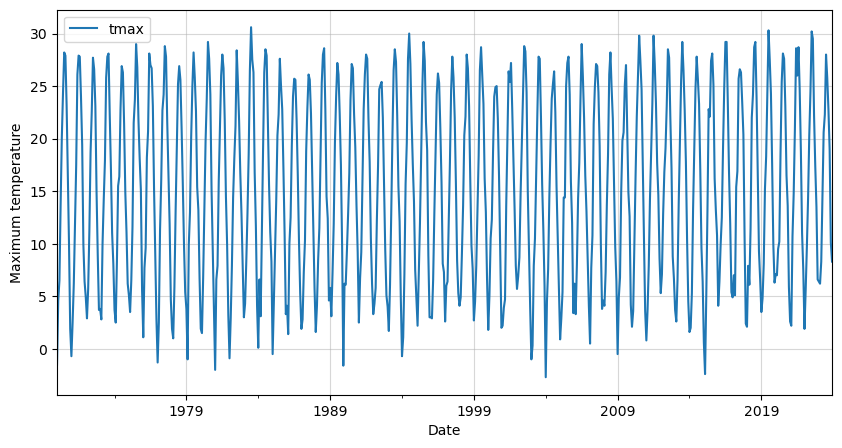

In [22]:
# Keep only the maximum temperature
df_temp_max = df[['tmax']]

# Visualize the data
df_temp_max.plot(figsize=(10,5))
plt.grid(alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Maximum temperature')
plt.show()

In [23]:
# Check for missing values
df_temp_max.isna().sum()

tmax    0
dtype: int64

## Decomposition

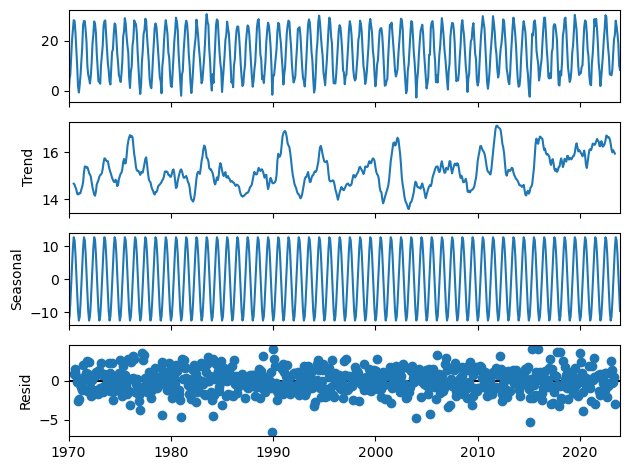

In [24]:
# Import statsmodels library
import statsmodels.api as sm

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(df_temp_max, 
                                          model='additive', 
                                          period=12)

# Extract the decomposed components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
decomposition.plot()
plt.show()

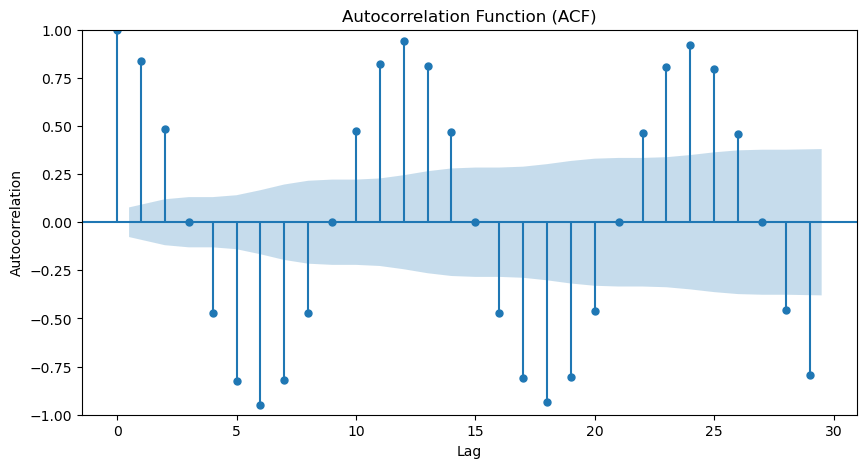

In [27]:
# confirming seasonal patterns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(df_temp_max, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

We can clearly see a seasonality of 12 for monthly


## Training a model

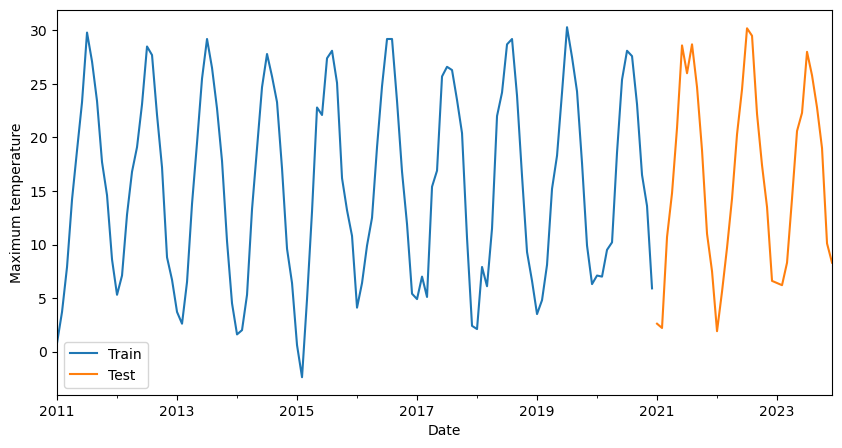

In [44]:
# Split into training and testing - can't do random split as data is in time order
df_train = df_temp_max.loc[:'2020']
df_test = df_temp_max.loc['2021':]

# Plot the last 10 years of training data and the 2 of testing
ax = df_train[-12*10:].plot(figsize=(10, 5))
df_test.plot(ax=ax)
plt.legend(['Train', 'Test'])
plt.xlabel('Date')
plt.ylabel('Maximum temperature')
plt.show()

### Forecast with SARIMAX

In [40]:
# p = Autoregressive order
# d = Differencing order
# q = Moving average order
# p,d,q
order = [1, 1, 1]

# P = Seasonal autoregressive order
# D = Seasonal differencing order
# Q = Seasonal moving average order
# m = Seasonal period
# P, D, Q, m
seasonal_order = [1, 1, 1, 6]

# create the model
model = sm.tsa.SARIMAX(df_train, 
                        order=order, 
                        seasonal_order=seasonal_order)

In [41]:
# fit the model
result = model.fit(disp=False)

In [42]:
# Show the summary
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              tmax   No. Observations:                  612
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 6)   Log Likelihood               -1409.212
Date:                           Tue, 06 Feb 2024   AIC                           2828.424
Time:                                   11:54:54   BIC                           2850.450
Sample:                               01-01-1970   HQIC                          2836.995
                                    - 12-01-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2549      0.042      6.062      0.000       0.172       0.337
ma.L1         -0.9787      0.013    -76.550      0.000      -1.004      -0.954
ar.S.L6       -0.9450      0.013    -74.703      0.000      -0.970      -0.920
ma.S.L6       -0.9996      0.965     -1.036      0.300      -2.891       0.892
sigma2         5.6224      5.378      1.045      0.296      -4.919      16.164
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.52   Prob(JB):                         0.98
Heteroskedasticity (H):               1.13   Skew:                             0.02
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

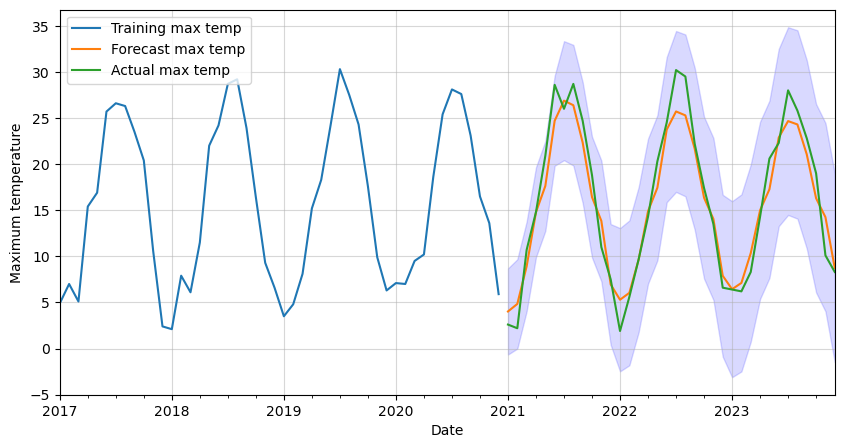

In [43]:
# Get forecast and confidence intervals for two years
forecast = result.get_forecast(steps=36)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot forecast with training data
ax = df_train[-12*4:].plot(figsize=(10,5))
forecast_values.plot()
df_test.plot(ax=ax)
plt.fill_between(forecast_values.index, 
                 confidence_intervals['lower tmax'], 
                 confidence_intervals['upper tmax'], 
                 color='blue',
                 alpha=0.15)
plt.legend(['Training max temp', 
            'Forecast max temp', 
            'Actual max temp'], 
           loc='upper left')
plt.xlabel('Date')
plt.ylabel('Maximum temperature')
plt.grid(alpha=0.5)
plt.show()

### Grid Search

In [31]:
import itertools
import math

# Define the range of values for p, d, q, P, D, Q, and m
p_values = range(0, 3)  # Autoregressive order
d_values = [0]          # Differencing order
q_values = range(0, 3)  # Moving average order
P_values = range(0, 2)  # Seasonal autoregressive order
D_values = range(0, 1)  # Seasonal differencing order
Q_values = range(0, 2)  # Seasonal moving average order
m_values = [12]         # Seasonal period

# Create all possible combinations of SARIMA parameters
param_combinations = list(itertools.product(p_values, 
                                            d_values, 
                                            q_values, 
                                            P_values, 
                                            D_values, 
                                            Q_values, 
                                            m_values))

# Initialize AIC with a large value
best_aic = float("inf")  
best_params = None

# Perform grid search
for params in param_combinations:
    order = params[:3]
    seasonal_order = params[3:]
    
    try:
        model = sm.tsa.SARIMAX(df_train, 
                               order=order, 
                               seasonal_order=seasonal_order,
                               )
        result = model.fit(disp=False)
        aic = result.aic
        
        # Ensure the convergence of the model
        if not math.isinf(result.zvalues.mean()):
            print(order, seasonal_order, aic)
        
            if aic < best_aic:
                best_aic = aic
                best_params = params
                
        else:
            print(order, seasonal_order, 'not converged')

    except:
        continue

# Print the best parameters and AIC
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)

(0, 0, 0) (0, 0, 0, 12) 5247.516690182766
(0, 0, 0) (0, 0, 1, 12) 4586.072788004358
(0, 0, 0) (1, 0, 0, 12) 2914.6418380598893


(0, 0, 0) (1, 0, 1, 12) 2552.271093530645
(0, 0, 1) (0, 0, 0, 12) 4544.909003834621


(0, 0, 1) (0, 0, 1, 12) 4076.392261120896
(0, 0, 1) (1, 0, 0, 12) 2886.948773149277


(0, 0, 1) (1, 0, 1, 12) 2518.712023456598
(0, 0, 2) (0, 0, 0, 12) 4080.2298534901906


(0, 0, 2) (0, 0, 1, 12) 3739.2107471687164
(0, 0, 2) (1, 0, 0, 12) 2875.4536505555848


(0, 0, 2) (1, 0, 1, 12) 2503.5042054937107
(1, 0, 0) (0, 0, 0, 12) 3710.810121279547
(1, 0, 0) (0, 0, 1, 12) 3397.859242851713
(1, 0, 0) (1, 0, 0, 12) 2877.718635061491


(1, 0, 0) (1, 0, 1, 12) 2508.591973144001
(1, 0, 1) (0, 0, 0, 12) 3523.6712301285484
(1, 0, 1) (0, 0, 1, 12) 3353.3498944812027
(1, 0, 1) (1, 0, 0, 12) 2864.563493141533


(1, 0, 1) (1, 0, 1, 12) 2505.454606130974
(1, 0, 2) (0, 0, 0, 12) 3388.2420952309894
(1, 0, 2) (0, 0, 1, 12) 3277.2807917559912
(1, 0, 2) (1, 0, 0, 12) 2866.5163917925875


(1, 0, 2) (1, 0, 1, 12) 2525.1464505812337
(2, 0, 0) (0, 0, 0, 12) 3374.0054525083942
(2, 0, 0) (0, 0, 1, 12) 3301.3349573039104
(2, 0, 0) (1, 0, 0, 12) 2868.498961867431


(2, 0, 0) (1, 0, 1, 12) 2501.846546443606
(2, 0, 1) (0, 0, 0, 12) 3371.211185354714
(2, 0, 1) (0, 0, 1, 12) 3284.7183639474797
(2, 0, 1) (1, 0, 0, 12) 2866.5179439319854


(2, 0, 1) (1, 0, 1, 12) 2523.7556992728473
(2, 0, 2) (0, 0, 0, 12) 3296.592194418892
(2, 0, 2) (0, 0, 1, 12) 3223.229161709567
(2, 0, 2) (1, 0, 0, 12) 2852.0513889732833


(2, 0, 2) (1, 0, 1, 12) 2522.0311938115456
Best Parameters: (2, 0, 0, 1, 0, 1, 12)
Best AIC: 2501.846546443606


In [32]:
model = sm.tsa.SARIMAX(df_train,
                       order=best_params[:3],
                       seasonal_order=best_params[3:])
result = model.fit(disp=False)

# Show the summary
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 tmax   No. Observations:                  612
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood               -1245.923
Date:                              Tue, 06 Feb 2024   AIC                           2501.847
Time:                                      11:45:16   BIC                           2523.930
Sample:                                  01-01-1970   HQIC                          2510.436
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2290      0.010     23.837      0.000       0.210       0.248
ar.L2          0.1215      0.010     12.058      0.000       0.102       0.141
ar.S.L12       0.9999   7.77e-05   1.29e+04      0.000       1.000       1.000
ma.S.L12      -0.9378      0.029    -32.551      0.000      -0.994      -0.881
sigma2         3.0742      0.137     22.486      0.000       2.806       3.342
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                10.58
Prob(Q):                              0.85   Prob(JB):                         0.01
Heteroskedasticity (H):               1.08   Skew:                            -0.01
Prob(H) (two-sided):                  0.59   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

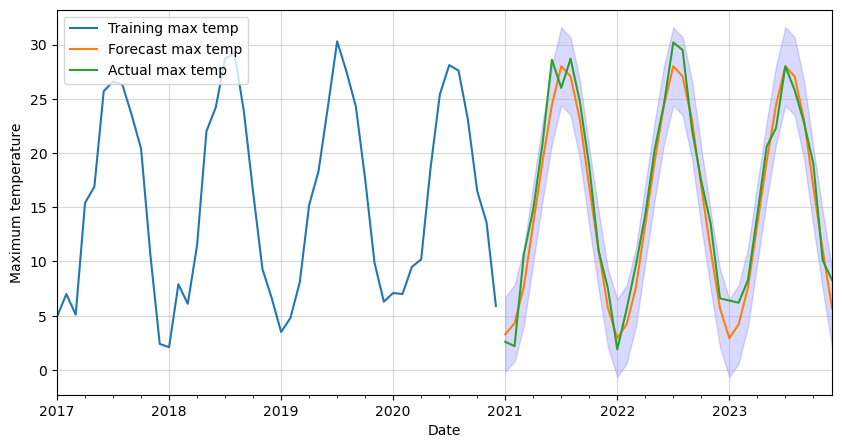

In [34]:

# Get forecast and confidence intervals for two years
forecast = result.get_forecast(steps=36)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot forecast with training data
ax = df_train[-12*4:].plot(figsize=(10,5))
forecast_values.plot()
df_test.plot(ax=ax)
plt.fill_between(forecast_values.index, 
                 confidence_intervals['lower tmax'], 
                 confidence_intervals['upper tmax'], 
                 color='blue',
                 alpha=0.15)
plt.legend(['Training max temp', 
            'Forecast max temp', 
            'Actual max temp'], 
           loc='upper left')
plt.xlabel('Date')
plt.ylabel('Maximum temperature')
plt.grid(alpha=0.5)
plt.show()

In [45]:
# Add extrenous data

ei_train = df['prcp'].loc[:'2020']
ei_test = df['prcp'].loc['2021':]


In [48]:
# let's first add this to the model

model = sm.tsa.SARIMAX(df_train,
                       order=best_params[:3],
                       seasonal_order=best_params[3:],
                       exog=ei_train)
result = model.fit(disp=False)

# Show the summary
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 tmax   No. Observations:                  612
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood               -1285.547
Date:                              Fri, 09 Feb 2024   AIC                           2583.094
Time:                                      10:31:00   BIC                           2609.594
Sample:                                  01-01-1970   HQIC                          2593.400
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
prcp          -0.0021      0.001     -1.622      0.105      -0.005       0.000
ar.L1          0.2720      0.036      7.455      0.000       0.200       0.344
ar.L2          0.1894      0.038      4.923      0.000       0.114       0.265
ar.S.L12       0.9959      0.001    719.703      0.000       0.993       0.999
ma.S.L12      -0.7418      0.034    -21.738      0.000      -0.809      -0.675
sigma2         3.6579      0.206     17.731      0.000       3.254       4.062
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                11.65
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.06
Prob(H) (two-sided):                  0.72   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
# grid search with extrenous data

# Define the range of values for p, d, q, P, D, Q, and m
p_values = range(0, 3)  # Autoregressive order
d_values = [0]          # Differencing order
q_values = range(0, 3)  # Moving average order
P_values = range(0, 2)  # Seasonal autoregressive order
D_values = range(0, 1)  # Seasonal differencing order
Q_values = range(0, 2)  # Seasonal moving average order
m_values = [12]         # Seasonal period

ei = [ei_train, None]

# Create all possible combinations of SARIMA parameters
param_combinations = list(itertools.product(p_values, 
                                            d_values, 
                                            q_values, 
                                            P_values, 
                                            D_values, 
                                            Q_values, 
                                            m_values,
                                            ei))



# Initialize AIC with a large value
best_aic = float("inf")  
best_params = None

# Perform grid search
for params in param_combinations:
    order = params[:3]
    seasonal_order = params[3:-1]
    ei = params[-1]

    try:
        model = sm.tsa.SARIMAX(df_train, 
                                order=order, 
                                seasonal_order=seasonal_order,
                                exog=ei
                                )
        result = model.fit(disp=False)
        aic = result.aic
        
        # Ensure the convergence of the model
        if not math.isinf(result.zvalues.mean()):
            print(order, seasonal_order, aic)
        
            if aic < best_aic:
                best_aic = aic
                best_params = params
                
        else:
            print(order, seasonal_order, 'not converged')

    except:
        continue

# Print the best parameters and AIC
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)

(0, 0, 0) (0, 0, 0, 12) 4789.356170811348
(0, 0, 0) (0, 0, 0, 12) 5247.516690182766
(0, 0, 0) (0, 0, 1, 12) 4491.294282471621
(0, 0, 0) (0, 0, 1, 12) 4586.072788004358
(0, 0, 0) (1, 0, 0, 12) 2909.1269185223828
(0, 0, 0) (1, 0, 0, 12) 2914.6418380598893
(0, 0, 0) (1, 0, 1, 12) 2542.761019839525


(0, 0, 0) (1, 0, 1, 12) 2552.271093530645
(0, 0, 1) (0, 0, 0, 12) 4429.0635275003315
(0, 0, 1) (0, 0, 0, 12) 4544.909003834621


(0, 0, 1) (0, 0, 1, 12) 4052.871439141714


(0, 0, 1) (0, 0, 1, 12) 4076.392261120896
(0, 0, 1) (1, 0, 0, 12) 2884.0208528854455
(0, 0, 1) (1, 0, 0, 12) 2886.948773149277


(0, 0, 1) (1, 0, 1, 12) 2523.7116780124657
(0, 0, 1) (1, 0, 1, 12) 2518.712023456598
(0, 0, 2) (0, 0, 0, 12) 4071.4598245502257
(0, 0, 2) (0, 0, 0, 12) 4080.2298534901906


(0, 0, 2) (0, 0, 1, 12) 3740.611749880399


(0, 0, 2) (0, 0, 1, 12) 3739.2107471687164
(0, 0, 2) (1, 0, 0, 12) 2872.8425146055647
(0, 0, 2) (1, 0, 0, 12) 2875.4536505555848


(0, 0, 2) (1, 0, 1, 12) 2530.329493477044


(0, 0, 2) (1, 0, 1, 12) 2503.5042054937107
(1, 0, 0) (0, 0, 0, 12) 3712.160606811025
(1, 0, 0) (0, 0, 0, 12) 3710.810121279547
(1, 0, 0) (0, 0, 1, 12) 3398.1740624376853
(1, 0, 0) (0, 0, 1, 12) 3397.859242851713
(1, 0, 0) (1, 0, 0, 12) 2875.3468168920467
(1, 0, 0) (1, 0, 0, 12) 2877.718635061491


(1, 0, 0) (1, 0, 1, 12) 2543.5910783305767
(1, 0, 0) (1, 0, 1, 12) 2508.591973144001
(1, 0, 1) (0, 0, 0, 12) 3525.6384919842517
(1, 0, 1) (0, 0, 0, 12) 3523.6712301285484
(1, 0, 1) (0, 0, 1, 12) 3354.2110605658318
(1, 0, 1) (0, 0, 1, 12) 3353.3498944812027


(1, 0, 1) (1, 0, 0, 12) 2861.5724896022302
(1, 0, 1) (1, 0, 0, 12) 2864.563493141533


(1, 0, 1) (1, 0, 1, 12) 2523.77734900762


(1, 0, 1) (1, 0, 1, 12) 2505.454606130974
(1, 0, 2) (0, 0, 0, 12) 3389.7658251008634
(1, 0, 2) (0, 0, 0, 12) 3388.2420952309894
(1, 0, 2) (0, 0, 1, 12) 3277.062582730511
(1, 0, 2) (0, 0, 1, 12) 3277.2807917559912


(1, 0, 2) (1, 0, 0, 12) 2863.6290089234917
(1, 0, 2) (1, 0, 0, 12) 2866.5163917925875


(1, 0, 2) (1, 0, 1, 12) 2516.059451395562


(1, 0, 2) (1, 0, 1, 12) 2525.1464505812337
(2, 0, 0) (0, 0, 0, 12) 3375.9964431630224
(2, 0, 0) (0, 0, 0, 12) 3374.0054525083942
(2, 0, 0) (0, 0, 1, 12) 3302.7377960617678
(2, 0, 0) (0, 0, 1, 12) 3301.3349573039104


(2, 0, 0) (1, 0, 0, 12) 2865.625380953955
(2, 0, 0) (1, 0, 0, 12) 2868.498961867431


(2, 0, 0) (1, 0, 1, 12) 2583.093508600332
(2, 0, 0) (1, 0, 1, 12) 2501.846546443606


(2, 0, 1) (0, 0, 0, 12) 3373.2054506283657
(2, 0, 1) (0, 0, 0, 12) 3371.211185354714


(2, 0, 1) (0, 0, 1, 12) 3408.6190553075267
(2, 0, 1) (0, 0, 1, 12) 3284.7183639474797
(2, 0, 1) (1, 0, 0, 12) 2866.5179439319854


(2, 0, 1) (1, 0, 1, 12) 2524.9255891890275
(2, 0, 1) (1, 0, 1, 12) 2523.7556992728473
(2, 0, 2) (0, 0, 0, 12) 3298.461830025003
(2, 0, 2) (0, 0, 0, 12) 3296.592194418892


(2, 0, 2) (0, 0, 1, 12) 3224.599962293592
(2, 0, 2) (0, 0, 1, 12) 3223.229161709567


(2, 0, 2) (1, 0, 0, 12) 2854.4212004140063
(2, 0, 2) (1, 0, 0, 12) 2852.0513889732833


(2, 0, 2) (1, 0, 1, 12) 2522.0311938115456
Best Parameters: (2, 0, 0, 1, 0, 1, 12, None)
Best AIC: 2501.846546443606


In [59]:
model = sm.tsa.SARIMAX(df_train,
                       order=best_params[:3],
                       seasonal_order=best_params[3:-1],
                       exog=best_params[-1])
result = model.fit(disp=False)

# Show the summary
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 tmax   No. Observations:                  612
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood               -1245.923
Date:                              Fri, 09 Feb 2024   AIC                           2501.847
Time:                                      10:43:32   BIC                           2523.930
Sample:                                  01-01-1970   HQIC                          2510.436
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2290      0.010     23.837      0.000       0.210       0.248
ar.L2          0.1215      0.010     12.058      0.000       0.102       0.141
ar.S.L12       0.9999   7.77e-05   1.29e+04      0.000       1.000       1.000
ma.S.L12      -0.9378      0.029    -32.551      0.000      -0.994      -0.881
sigma2         3.0742      0.137     22.486      0.000       2.806       3.342
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                10.58
Prob(Q):                              0.85   Prob(JB):                         0.01
Heteroskedasticity (H):               1.08   Skew:                            -0.01
Prob(H) (two-sided):                  0.59   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""